## Capstone First Draft (Data Exploratory Analysis)

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.metrics import  mean_absolute_error,mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn import set_config

### The Data: Wake County Properties

The dataset for the capstone project is two `.csv` files generated by Wake County’s Computer Assisted Mass Appraisal (CAMA) system that can be found on its website (https://www.wake.gov/departments-government/tax-administration/data-files-statistics-and-reports/real-estate-property-data-files).
The file names and descriptions of the data are as follows:

- `sales.csv`: Qualified sales in Wake County from October 2nd, 2023, to September 22nd, 2025, and information on zoning, location and some property characteristics.
- `properties.csv`: An exhaustive list of characteristics of all the properties in Wake County. Code Description.pdf provides the meaning behind the coded features' values.

Each dataset is loaded below, and basic info displayed.

In [3]:
sales = pd.read_csv('Capstone_data/sales.csv')
properties = pd.read_csv('Capstone_data/properties.csv')

C:\Users\megha\AppData\Local\Temp\ipykernel_32320\3221007503.py:2: DtypeWarning: Columns (12,33,47,70,71,72,79) have mixed types. Specify dtype option on import or set low_memory=False.
  properties = pd.read_csv('Capstone_data/properties.csv')


In [149]:
sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56293 entries, 0 to 56292
Data columns (total 41 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   REID                           56293 non-null  int64         
 1   PIN_NUM                        56293 non-null  int64         
 2   PIN_EXT                        56293 non-null  int64         
 3   SALE_DEED_BOOK                 56293 non-null  int64         
 4   SALE_DEED_PAGE                 56293 non-null  int64         
 5   SALE_PRICE                     56293 non-null  int64         
 6   SALE_DATE                      56293 non-null  datetime64[ns]
 7   SALE_TYPE                      56293 non-null  object        
 8   PARCEL_ASSD_VALUE_ATSALE       56166 non-null  float64       
 9   LAND_ASSD_VALUE_ATSALE         55762 non-null  float64       
 10  PARCEL_DEEDED_ACREAGE_ATSALE   56293 non-null  float64       
 11  TOTAL_HEATED_AR

In [150]:
sales.head()

,REID,PIN_NUM,PIN_EXT,SALE_DEED_BOOK,SALE_DEED_PAGE,SALE_PRICE,SALE_DATE,SALE_TYPE,PARCEL_ASSD_VALUE_ATSALE,LAND_ASSD_VALUE_ATSALE,...,TOWNSHIP_DESC,FIRE_DISTRICT,SPECIAL_DISTRICT,STREET_NUM,DIRECTIONAL_PREFIX,STREET_NAME,STREET_TYPE,DIRECTIONAL_SUFFIX,STREET_MISC,ZIP
0,491531,1851807038,0,20017,1975,135000,2025-09-22,Land,39996.0,39996.0,...,Wake Forest,NaN,NaN,0,NaN,LATHAM OAKS,AVE,NaN,NaN,27587.0
1,518746,1700273853,0,20017,2049,301000,2025-09-22,Package,286878.0,65000.0,...,St. Mary's,NaN,NaN,292,NaN,GRAND SILO,RD,NaN,NaN,27603.0
2,312870,1850505543,0,20017,2123,665000,2025-09-22,Package,655524.0,100000.0,...,Wake Forest,NaN,NaN,6121,NaN,TIFFIELD,WAY,NaN,NaN,27587.0
3,514138,1731556290,0,20018,82,297500,2025-09-22,Package,281716.0,50000.0,...,St. Mary's,NaN,NaN,6654,NaN,GIBRALTAR ROCK,DR,NaN,NaN,27610.0
4,209630,1747431475,0,20017,1972,298000,2025-09-22,Package,360700.0,130000.0,...,WAKE FOREST,NaN,NaN,4244,NaN,CASHEW,DR,NaN,NaN,27616.0


In [151]:
sales['SALE_DATE'] = pd.to_datetime(sales['SALE_DATE'])

In [152]:
sales['SALE_DATE'].max()

Timestamp('2025-09-22 00:00:00')

In [153]:
sales['SALE_DATE'].min()

Timestamp('2023-10-02 00:00:00')

In [154]:
properties.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 463693 entries, 0 to 463692
Data columns (total 87 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   OWNER1                          463692 non-null  object 
 1   OWNER2                          97183 non-null   object 
 2   Mailing_address1                463693 non-null  object 
 3   Mailing_Address2                463657 non-null  object 
 4   Mailing_Address3                25442 non-null   object 
 5   REAL_ESTATE_ID                  463693 non-null  int64  
 6   CARD_NUMBER                     463693 non-null  int64  
 7   NUMBER_OF_CARDS                 463693 non-null  int64  
 8   Street_Number                   463693 non-null  int64  
 9   Street_Prefix                   17549 non-null   object 
 10  Street_Name                     463693 non-null  object 
 11  Street_Type                     462312 non-null  object 
 12  Street_Suffix   

In [155]:
properties.head(3)

,OWNER1,OWNER2,Mailing_address1,Mailing_Address2,Mailing_Address3,REAL_ESTATE_ID,CARD_NUMBER,NUMBER_OF_CARDS,Street_Number,Street_Prefix,...,Land_Deferred_code,Land_Deferred_Amount,Historic_Deferred_code,Historic_Deferred_Amount,RECYCLED_UNITS,Disq_and_Qual_flag,Land_Disq_and_Qual_flag,TYPE_AND_USE,PHYSICAL_CITY,PHYSICAL_ZIP_CODE
0,NORTHGATE PROPERTIES LLC,NaN,8465 LENTIC CT,RALEIGH NC 27615-4964,NaN,1,1,1,1506,NaN,...,NaN,0,NaN,0,0,NaN,NaN,NaN,RALEIGH,27604.0
1,BONES 13 LLC,NaN,306 MIDENHALL WAY,CARY NC 27513-5569,NaN,3,1,2,6012,NaN,...,NaN,0,NaN,0,0,A,NaN,20.0,RALEIGH,27617.0
2,BONES 13 LLC,NaN,306 MIDENHALL WAY,CARY NC 27513-5569,NaN,3,2,2,6012,NaN,...,NaN,0,NaN,0,0,A,NaN,34.0,RALEIGH,27617.0


### Background and Objective
Since the global pandemic Covid broke in 2020, the state of North Carolina has seen a surge of population from migration both nationally and internationally. Within the US, tens of thousands of people moved from New York, Pennsylvania and California to North Carolina every year attracted by its high-quality public education, newer infrastructure, great parks, good public safety, lower income and property tax rate and so on, bidding the housing prices up significantly. Wake county sits in the heart of the research triangle. It has seen its personal property tax base increase from 6.0 billion to 11.6 billion from 2020 to 2025, almost doubled.


The objective of this analysis is to predict single family housing prices in Wake County, North Carolina based on property location and characteristics. It aims to find what factors predict single family housing prices in Wake County, and to provide insights into the hot North Carolina real estate market for relocating families.

#### Data Cleaning
Drop columns in `sales` DataFrame that are repetitive or uninformative and select columns in `properties` DataFrame that provides additional information on properties sold in the past year. Drop columns related to assessed property values because their correlation with sales price is very high and provides little insight into the factors contributing to the value.

In [157]:
sales2 = sales.drop(['LAND_VALUE_ASSD','BLDG_VALUE_ASSD','TOTAL_PROP_VALUE_ASSD','TOTAL_OBLDG_VALUE_ASSD','PARCEL_ASSD_VALUE_ATSALE','LAND_ASSD_VALUE_ATSALE','DEEDED_ACREAGE','PARCEL_ASSD_VALUE_CURRENT','TOTAL_HEATED_AREA','LAND_ASSD_VALUE_CURRENT','PARCEL_DEEDED_ACREAGE_CURRENT','PIN_NUM','PIN_EXT','SALE_DEED_BOOK','SALE_DEED_PAGE', 'VCS','STREET_NUM','DIRECTIONAL_PREFIX','STREET_NAME','STREET_MISC','DIRECTIONAL_SUFFIX','TOTAL_HEATED_AREA_CURRENT','TOWNSHIP','FIRE_DISTRICT','SPECIAL_DISTRICT'],axis=1)
sales2.shape

(56293, 16)

Select SALE_TYPE that is Package meaning both land and housing were sold in the transaction.

In [158]:
sales3 = sales2[sales2['SALE_TYPE']=='Package']
sales3.shape

(42601, 16)

In [159]:
sales4 = sales3.drop_duplicates()
sales4.shape

(42507, 16)

In [160]:
properties2 = properties[['REAL_ESTATE_ID', 'PROPERTY_DESCRIPTION','Land_classification','NUM_of_Rooms','UNITS','UTILITIES','Year_of_Addition','Foundation_Basement','Exterior_Wall','HEAT',  'AIR', 'BATH','GRADE', 'Assessed_Grade_Difference','PHYSICAL_CITY','TYPE_AND_USE']] 
properties2.shape

(463693, 16)

In [161]:
properties3 = properties2.drop_duplicates()
properties3.shape


(456410, 16)

Merge `sales3` and `properties2` DataFrames based on key `REAL_ESTATE_ID` or `REID`, while keeping only records of properties in the `sales3` DataFrame.

In [162]:
df = pd.merge(left = sales4, right = properties3, left_on = "REID", right_on = "REAL_ESTATE_ID", how = "left")

In [163]:
df.shape

(42865, 32)

In [192]:
df.head()

,REID,SALE_PRICE,SALE_DATE,SALE_TYPE,PARCEL_DEEDED_ACREAGE_ATSALE,TOTAL_HEATED_AREA_ATSALE,ZONING,BLDG_USE_DESC,YEAR_BUILT,STORY_HEIGHT,...,Year_of_Addition,Foundation_Basement,Exterior_Wall,HEAT,AIR,BATH,GRADE,Assessed_Grade_Difference,PHYSICAL_CITY,TYPE_AND_USE
0,518746,301000,2025-09-22,Package,0.05,1568.0,MF-A,SINGLFAM,2025.0,2S,...,0.0,A,Z,A,A,D,C,100.0,RALEIGH,1.0
1,312870,665000,2025-09-22,Package,0.22,4575.0,GR3,SINGLFAM,2004.0,1.88S,...,0.0,D,A,A,A,F,B,120.0,WAKE FOREST,1.0
2,514138,297500,2025-09-22,Package,0.05,1428.0,R-6,SINGLFAM,2025.0,2S,...,0.0,NaN,Z,A,A,D,C,100.0,RALEIGH,1.0
3,209630,298000,2025-09-22,Package,0.30,1584.0,R-4,SINGLFAM,1995.0,1S,...,0.0,D,A,A,A,C,C+05,105.0,RALEIGH,1.0
4,518906,423500,2025-09-22,Package,0.13,NaN,R4,NaN,NaN,NaN,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,RALEIGH,NaN


Select single family property type. The corresponding value is 1 in the TYPE_AND_USE column.

In [265]:
df2 = df[df['TYPE_AND_USE']==1]

Double check with column Building Use Description and number of units.

In [266]:
df2['UNITS'].value_counts()

UNITS
1.0    39692
0.0      443
4.0        1
Name: count, dtype: int64

In [267]:
df2['BLDG_USE_DESC'].value_counts()

BLDG_USE_DESC
SINGLFAM    40131
TWOFAM          2
WAREHSE         1
CHURCH          1
THREEFAM        1
Name: count, dtype: int64

Remove the rows that are inconsistent with single family usage, and drop columns that are repetitive and have uniform values.


In [268]:
df2 = df2[(df2['BLDG_USE_DESC'] == 'SINGLFAM') & (df2['UNITS'] == 1)]
df2.shape

(39687, 32)

In [269]:
df2 = df2.drop(['TYPE_AND_USE','REAL_ESTATE_ID','BLDG_USE_DESC','UNITS','SALE_TYPE'],axis=1)
df2.shape

(39687, 27)

In [270]:
df2['Year_of_Addition'].value_counts(dropna=False)

Year_of_Addition
0.0       38916
2024.0      135
2025.0      113
2023.0       76
2021.0       62
2020.0       60
2019.0       55
2022.0       33
2011.0       27
2018.0       24
2008.0       21
2015.0       21
2006.0       19
2016.0       18
2009.0       16
2005.0       16
2017.0       15
2012.0       15
2013.0       10
2007.0       10
2014.0       10
2010.0        9
1998.0        2
2026.0        2
2000.0        1
1979.0        1
Name: count, dtype: int64

In [271]:
df2['YEAR_BUILT'].value_counts(dropna=False)

YEAR_BUILT
2024.0    8362
2023.0    4771
2025.0    1860
2006.0     848
2005.0     822
          ... 
1911.0       1
1904.0       1
1934.0       1
1876.0       1
1872.0       1
Name: count, Length: 128, dtype: int64

Convert datatype of ZIP from float to string.

In [272]:
df2['ZIP'] = df2['ZIP'].fillna('missing')
df2['ZIP'] = df2['ZIP'].astype(str)

Convert datatype story height from object to float.

In [273]:
df2['STORY_HEIGHT'] = (
    df2['STORY_HEIGHT']
    .str.replace('S', '', regex=False)  # remove 'S'
    .astype(float)                      # convert to number
)

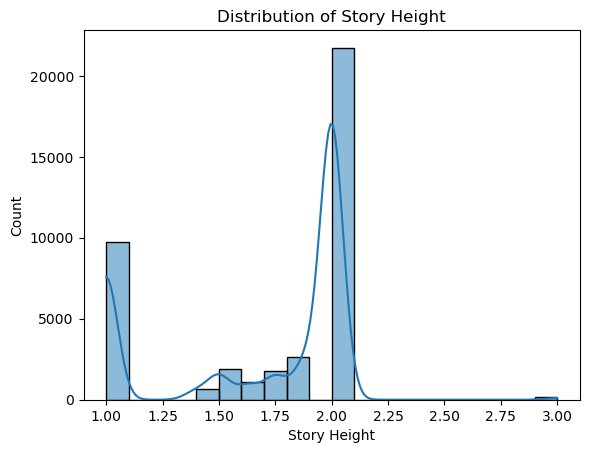

In [274]:
sns.histplot(df2['STORY_HEIGHT'], bins=20, kde=True)
plt.xlabel('Story Height')
plt.ylabel('Count')
plt.title('Distribution of Story Height')
plt.savefig("Capstone_image/story_height_hist_plot.png")

The distribution shows that most of the single-family houses sold had a story height of 2. Story heights of 1 or 2 are the most common.

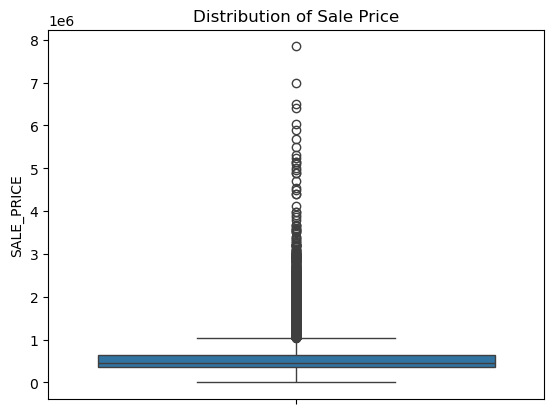

In [275]:
sns.boxplot(df2['SALE_PRICE'])
plt.title("Distribution of Sale Price")
plt.savefig("Capstone_image/sale_price_box_plot.png")

The box plot shows that the upper limit for standard range of single-family sales in Wake County is a little above 1 million USD, with median sales price of around half a million USD. 

Select single family properties that were sold for more than 50,000 USD and less than 3 million USD to eliminate entry error.

In [276]:
df3 = df2[(df2['SALE_PRICE']<3000000) & (df2['SALE_PRICE']>50000)]


In [277]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
Index: 39437 entries, 0 to 42864
Data columns (total 27 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   REID                          39437 non-null  int64         
 1   SALE_PRICE                    39437 non-null  int64         
 2   SALE_DATE                     39437 non-null  datetime64[ns]
 3   PARCEL_DEEDED_ACREAGE_ATSALE  39437 non-null  float64       
 4   TOTAL_HEATED_AREA_ATSALE      39364 non-null  float64       
 5   ZONING                        39437 non-null  object        
 6   YEAR_BUILT                    39437 non-null  float64       
 7   STORY_HEIGHT                  39407 non-null  float64       
 8   DESIGN_STYLE_DESC             39407 non-null  object        
 9   CORP_LIMIT_DESC               34837 non-null  object        
 10  PLANNING_JURISDICTION         39437 non-null  object        
 11  TOWNSHIP_DESC                 394

#### Time Series  Analysis for Properties with Duplicate Keys

Some properties that have duplicate keys were transacted more than once. Some at similar prices and some at higher prices after improvement. We apply time series analysis to these records to see the trend.

In [278]:
# Create DataFrame dupe_keys for the REIDs that appear more than once
dupe_keys = df3[df3['REID'].duplicated()]
dupe_keys.shape

(1856, 27)

In [279]:
time_series = dupe_keys[['SALE_DATE','SALE_PRICE']].set_index('SALE_DATE')

In [280]:
stl = STL(time_series['SALE_PRICE'], period=12)
results = stl.fit()

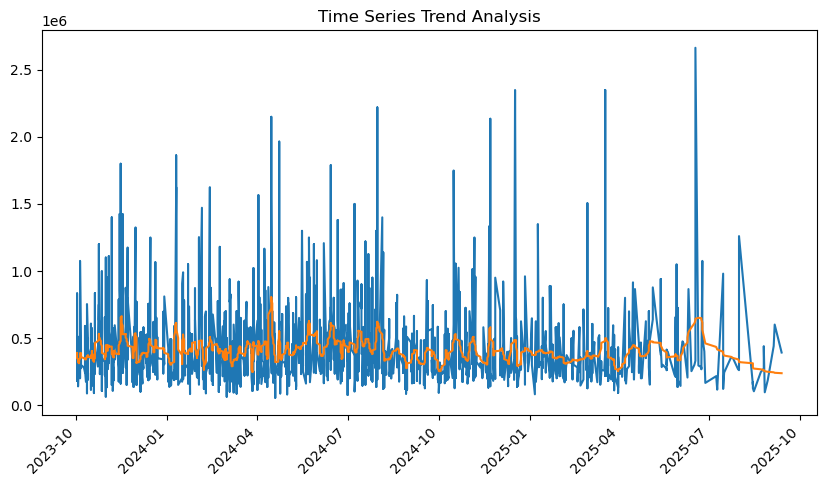

In [281]:
##sns.lineplot(data = dupe_keys, x='SALE_DATE', y='SALE_PRICE')
plt.figure(figsize=(10, 5))
plt.plot(time_series['SALE_PRICE'])
plt.plot(results.trend)
plt.xticks(rotation=45, ha="right")
plt.title("Time Series Trend Analysis")
plt.savefig("Capstone_image/time_series_trend_analysis.png")

Time series trend analysis shows that real estate prices in Wake County have fluctuated around the mean from October 2023 to October 2025, with a visible downtrend in the second half of 2025.

### Baseline Regression Model with Quantitative Features
Build a baseline linear regression model with quantitative features.

In [282]:
numerical_columns= df3.select_dtypes(include=['float64', 'int64']).columns.tolist()

In [283]:
df3_num = df3[numerical_columns]
df3_num = df3_num.dropna()

In [284]:
# Define features (X) and target (y)
X = df3_num.drop(['SALE_PRICE','REID'], axis=1)
y = df3_num['SALE_PRICE']

In [285]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [286]:
linreg_pipe = Pipeline([('scaler', StandardScaler()),
                        ('linreg', LinearRegression())])
linreg_pipe.fit(X_train, y_train)
linreg_train_mse = mean_squared_error(y_train, linreg_pipe.predict(X_train))
linreg_test_mse = mean_squared_error(y_test, linreg_pipe.predict(X_test))
print(linreg_train_mse)
print(linreg_test_mse)


16367346572.57112
16890946745.286167


In [287]:
coefs = pd.DataFrame({
    'feature': X.columns,
    'coefficient': linreg_pipe.named_steps['linreg'].coef_
}).assign(abs_coef=lambda df: df['coefficient'].abs()) \
  .sort_values('abs_coef', ascending=False)
print(coefs)

                        feature   coefficient      abs_coef
1      TOTAL_HEATED_AREA_ATSALE  1.638926e+05  1.638926e+05
6     Assessed_Grade_Difference  1.479518e+05  1.479518e+05
3                  STORY_HEIGHT -1.756688e+04  1.756688e+04
0  PARCEL_DEEDED_ACREAGE_ATSALE  1.523678e+04  1.523678e+04
2                    YEAR_BUILT -1.148821e+04  1.148821e+04
5              Year_of_Addition  5.170606e+03  5.170606e+03
4                  NUM_of_Rooms  2.910383e-11  2.910383e-11


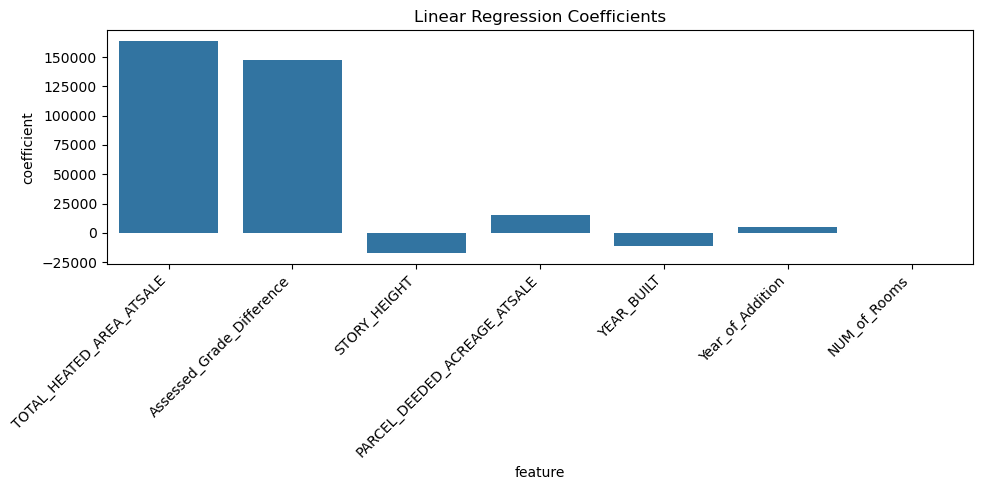

In [288]:
plt.figure(figsize=(10, 5))
sns.barplot(data=coefs, x="feature", y="coefficient")
plt.xticks(rotation=45, ha="right")
plt.title("Linear Regression Coefficients")
plt.tight_layout()
plt.savefig("Capstone_image/linreg_coefficients.png")

The baseline linear regression model using all quantitative features indicates that sale price is positively associated with total heated area at sale, assessed grade difference (reflecting the property’s overall condition relative to comparable properties), parcel deeded acreage at sale, and year of addition. In contrast, sale price is negatively associated with story height and year built, while the number of rooms has minimal impact. The four most influential predictors are total heated area at sale, assessed grade difference, story height, and parcel deeded acreage at sale.

### Addint Nonlinear Features
Use PolynomialFeatures to the degree of 2 and SequentialFeatureSelection transformer to select the 4 important features.

In [289]:
sequential_pipe = Pipeline([('poly_features', PolynomialFeatures(degree = 2, include_bias = False)),
                            ('scaler', StandardScaler()),
                            ('selector', SequentialFeatureSelector(LinearRegression(), n_features_to_select=4)),
                           ('linreg', LinearRegression())])
sequential_pipe 

Pipeline(steps=[('poly_features', PolynomialFeatures(include_bias=False)),
                ('scaler', StandardScaler()),
                ('selector',
                 SequentialFeatureSelector(estimator=LinearRegression(),
                                           n_features_to_select=4)),
                ('linreg', LinearRegression())])

In [290]:
sequential_pipe.fit(X_train, y_train)
sequential_train_mse = mean_squared_error(y_train, sequential_pipe.predict(X_train))
sequential_test_mse = mean_squared_error(y_test, sequential_pipe.predict(X_test))

In [291]:
print(sequential_train_mse)
print(sequential_test_mse)

15987298116.088076
15658904582.649601


In [292]:
sfs = sequential_pipe.named_steps['selector']
mask = sfs.get_support() 
selected_indices = mask.nonzero()[0]
print(selected_indices)
poly = sequential_pipe.named_steps['poly_features']
feature_names = poly.get_feature_names_out(X.columns)
selected_feature_names = feature_names[selected_indices]
print(selected_feature_names)

[ 6 14 19 21]
['Assessed_Grade_Difference' 'TOTAL_HEATED_AREA_ATSALE^2'
 'TOTAL_HEATED_AREA_ATSALE Assessed_Grade_Difference'
 'YEAR_BUILT STORY_HEIGHT']


After building a pipeline to capture nonlinearity and selecting four key features, the mean squared error improved compared to the baseline model. Using second-degree polynomial features and a sequential feature selection process, the selected predictors were: assessed grade difference; total heated area at sale squared; the interaction between assessed grade difference and total heated area at sale; and the interaction between year built and story height.

### Adding Qualitative Features

In [296]:
categorical_columns = df3.select_dtypes(include=['object']).columns.tolist()
print(categorical_columns)

['ZONING', 'DESIGN_STYLE_DESC', 'CORP_LIMIT_DESC', 'PLANNING_JURISDICTION', 'TOWNSHIP_DESC', 'STREET_TYPE', 'ZIP', 'PROPERTY_DESCRIPTION', 'Land_classification', 'UTILITIES', 'Foundation_Basement', 'Exterior_Wall', 'HEAT', 'AIR', 'BATH', 'GRADE', 'PHYSICAL_CITY']


Among these columns, Grade and Bath are ordinal variables, meaning their values have a natural ranking, while the remaining variables are nominal and do not have an inherent order.

In [297]:
df3['BATH'].value_counts()

BATH
D    16040
F     9529
C     5625
E     5457
A     1097
J      834
B      820
I        3
H        2
Name: count, dtype: int64

In [298]:
df4 = df3.drop(['REID','SALE_DATE','PROPERTY_DESCRIPTION'], axis=1).dropna()
df4.shape

(19730, 24)

In [299]:
X2 = df4.drop(['SALE_PRICE'],axis=1)
y2 = df4['SALE_PRICE']

In [70]:
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.2, random_state=42)